<a href="https://colab.research.google.com/github/brownsloth/3by3/blob/main/d2l_linear_nns_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [75]:
%matplotlib inline
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
from torch.utils import data

## Timer/Benchmarking utils

In [22]:
class Timer:
  """Record multiple running times"""
  def __init__(self) -> None:
    self.times = []
    self.tik = None
    # self.start()

  def start(self):
    self.tik = time.time()

  def stop(self):
    if not self.tik:
      raise Exception("Please call start first")
    self.times.append(time.time() - self.tik)
    self.tik = None
    return self.times[-1]

  def avg(self):
    return sum(self.times) / len(self.times)

  def sum(self):
    return sum(self.times)

  def cumsum(self):
    return np.array(self.times).cumsum().tolist()

  def reset(self):
    self.times = []
    self.tik = None

## How vectorization helps

In [23]:
nelem = 1000
a = torch.ones(nelem)
b = torch.ones(nelem)
c = torch.zeros(nelem)

timer = Timer()

nexperiments = 1000

for k in range(nexperiments):
  timer.start()
  for i in range(nelem):
    c[i] = a[i]+b[i]
  timer.stop()
print(f'{timer.avg(): .9f} sec')

timer.reset()

for k in range(nexperiments):
  timer.start()
  d = a + b
  timer.stop()
print(f'{timer.avg(): .9f} sec')

 0.010651650 sec
 0.000002389 sec


## Mathematical Functions

In [24]:
def gaussian_std_normal(x, mu, sigma):
  """Normal distribution function. mu= mean, sigma=variance, x=np array."""
  ## Need to use np.exp and not math.exp since x is not a scalar
  exp_part = np.exp(-0.5 * ( (x - mu) / sigma)**2)
  return exp_part / math.sqrt(2 * math.pi * sigma)

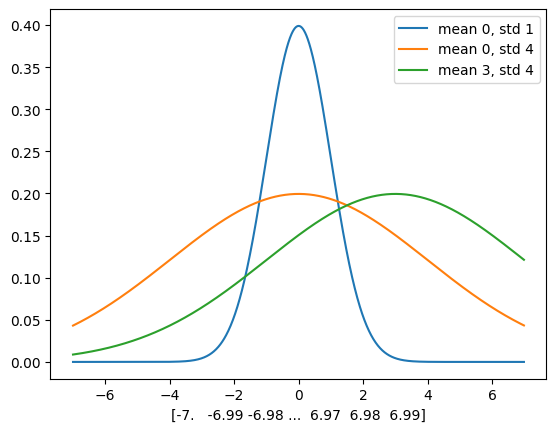

In [25]:
x = np.arange(-7,7,0.01)

param_combos = [(0, 1), (0, 4), (3, 4)]
for params in param_combos:
  plt.plot(x, gaussian_std_normal(x, *params))

plt.legend([f'mean {m}, std {s}' for m,s in param_combos])
plt.xlabel(x)
plt.show()

## Linear Regression Implementation from Scratch

In [26]:
torch.normal(0,1, (2, 2))

tensor([[-0.5883,  2.3915],
        [ 1.7703, -1.9170]])

In [33]:
num_examples = 2
embedding_size = 3
num_outputs = 4
torch.normal(0, 1, size=(num_examples, embedding_size))

tensor([[-0.1788,  0.4670,  0.5698],
        [-1.0184, -0.0959,  0.9711]])

In [34]:
t = torch.matmul(
    torch.normal(0, 1, size=(num_examples, embedding_size)),
    torch.normal(0, 1, size=(embedding_size, num_outputs))
)
print(t)
print(t.reshape(-1, 1))

tensor([[ 0.0209, -1.4850,  0.1335,  0.0048],
        [-0.1452,  1.1273, -0.6259,  1.9235]])
tensor([[ 0.0209],
        [-1.4850],
        [ 0.1335],
        [ 0.0048],
        [-0.1452],
        [ 1.1273],
        [-0.6259],
        [ 1.9235]])


### Creating a synthetic dataset

In [36]:
def synthetic_data(w, b, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

torch.Size([1000, 2])
torch.Size([1000, 1])
features: tensor([ 0.5026, -0.1851]) 
label: tensor([5.8210])


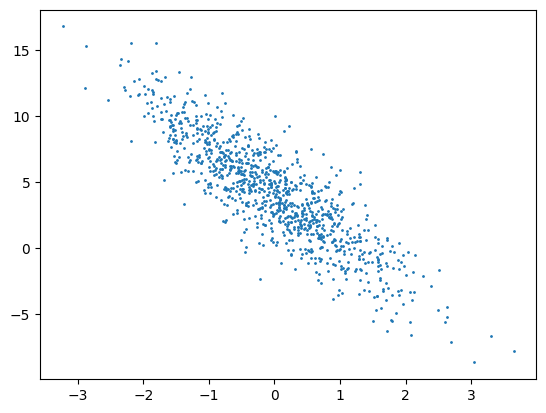

In [42]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features.shape)
print(labels.shape)

print('features:', features[0],'\nlabel:', labels[0])

plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

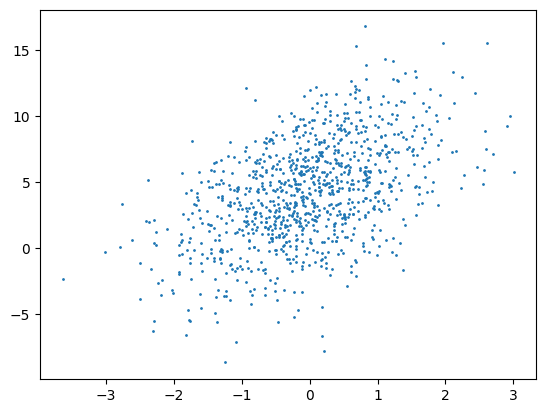

In [44]:
plt.scatter(features[:, 0].detach().numpy(), labels.detach().numpy(), 1);

### Reading the Dataset

In [51]:
## a generic iterator in python (using a generator)
def counter_generator(start, end):
    current = start
    while current <= end:
        yield current  # Pauses execution and returns 'current' value
        current += 1

# Calling the function returns a generator object (which is an iterator)
my_generator = counter_generator(1, 5)

for i in my_generator:
    print(i)

# The iterator is exhausted now
for i in my_generator:
    print(i)

1
2
3
4
5


In [52]:
## Custom minibatch iterator
def data_iter(batch_size, features, labels):
  ## A minibatch of features of batch_size size
  num_examples = len(features)
  indices = list(range(num_examples))
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

In [54]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break

tensor([[-0.3841,  0.0761],
        [-0.9152,  0.9788],
        [ 1.0831,  0.7859],
        [-0.5131,  0.9545],
        [-1.7741,  0.0402],
        [-0.6956, -0.1411],
        [-0.1086,  0.0903],
        [-0.5619,  0.6663],
        [ 0.3980,  0.1996],
        [ 0.2258, -0.0453]]) 
 tensor([[ 3.1609],
        [-0.9506],
        [ 3.7003],
        [-0.0797],
        [ 0.5169],
        [ 3.3104],
        [ 3.6865],
        [ 0.8100],
        [ 4.3157],
        [ 4.8162]])


This custom iterator is inefficient in ways that might get us in trouble on real problems. For example, it requires that we load all the data in memory and that we perform lots of random memory access.

### Initializing model params



In [55]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### Defining the model

In [56]:
def linreg(X, w, b):
  """Linear regression model Xw + b"""
  return torch.matmul(X, w) + b

### Define the loss function

In [61]:
def squared_loss(y_hat, y):
  # Note that we are not normalizing by batch size here!
  # Also we are not reducing/Summing
  return (y_hat - y.reshape(y_hat.shape))**2 / 2

### The optimization algo

In [59]:
def sgd(params, lr, actual_batch_size): # Modified to accept actual_batch_size
  """Minibatch stochastic gradient descent (SGD)."""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / actual_batch_size # Divide by actual_batch_size
      param.grad.zero_()

### Training process

In [60]:
## Defining hyperparams
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [73]:
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    ## 1. forward pass
    y_out = net(X, w, b)
    ## 2. loss computation
    l = loss(y_out, y)
    ## 3. backward pass
    l.sum().backward()
    ## 4. Peform optimization and update params
    sgd([w, b], lr, len(X)) # Pass len(X) as the actual batch size
    ## could have used batch_size instead of len(X) if
    ## num_examples was exactly divisible by batch_size
    ## and if each batch was equally sized

  with torch.no_grad():
    ## not normalizing in the loss method etc. helps here
    ## when we need to compute loss at the end of each epoch
    ## not really using this loss for backprop tho just for observability
    ## Also notice here we use a .mean()
    ## which is basically what we also do during minibatch loss calculation
    train_l = loss(net(features, w, b), labels)
    print(f'epoch: {epoch + 1}, loss: {float(train_l.mean()):f}, w: {w}')

epoch: 1, loss: 0.000051, w: tensor([[ 1.9997],
        [-3.4002]], requires_grad=True)
epoch: 2, loss: 0.000051, w: tensor([[ 2.0001],
        [-3.4005]], requires_grad=True)
epoch: 3, loss: 0.000051, w: tensor([[ 1.9996],
        [-3.4003]], requires_grad=True)


In [65]:
## Here we know the exact params
## which wont be true in a lot of problems
## but still here we do so we can estimate error as:

print(f'error in estimating w: {(true_w - w.reshape(true_w.shape)).detach()}')
print(f'error in estimating b: {(true_b - b).detach()}')

error in estimating w: tensor([ 5.2547e-04, -6.5327e-05])
error in estimating b: tensor([0.0003])


say we set the initial weights close to 0

In [67]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
w = torch.tensor([0.0, 0.0], requires_grad=True)
for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    ## 1. forward pass
    y_out = net(X, w, b)
    ## 2. loss computation
    l = loss(y_out, y)
    ## 3. backward pass
    l.sum().backward()
    ## 4. Peform optimization and update params
    sgd([w, b], lr, batch_size)

  with torch.no_grad():
    ## not normalizing in the loss method etc. helps here
    ## when we need to compute loss at the end of each epoch
    ## not really using this loss for backprop tho just for observability
    ## Also notice here we use a .mean()
    ## which is basically what we also do during minibatch loss calculation
    train_l = loss(net(features, w, b), labels)
    print(f'epoch: {epoch + 1}, loss: {float(train_l.mean()):f}')

epoch: 1, loss: 0.017862
epoch: 2, loss: 0.000092
epoch: 3, loss: 0.000051


In [68]:
print(f'error in estimating w: {(true_w - w.reshape(true_w.shape)).detach()}')
print(f'error in estimating b: {(true_b - b).detach()}')

error in estimating w: tensor([ 0.0002, -0.0003])
error in estimating b: tensor([-0.0004])


SGD is mostly able to find a set of params that are good enough to have accurate predictions in most samples

In more complex problems and datasets, there are multiple sets of params which can all be equally optimal (since there is no single solution) and sgd allows us to reach a solution altho the params we reach might be different each time we train from scratch

## Linear Regression implementation with libs

### Reading the Dataset

In [76]:
? data.TensorDataset

In [77]:
def load_array(data_arrays, batch_size, is_train=True):
  """Create a pytorch data iterator"""
  # data_arrays: tensors that have the same size of the first dimension.
  # like = number of examples
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [83]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

## check the first sample
# next(iter(data_iter))

### Defining the model

In [85]:
from torch import nn

input_embedding_dimension = 2
output_dimension = 1
net = nn.Sequential(
    ## if input is (num_examples, input_embedding_dimension)
    ## output will be (num_examples, output_dimension)
    ## Wt will be (input_embedding_dimension, output_dimension)
    nn.Linear(input_embedding_dimension, output_dimension)
)
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)


### Initializing model params

In [89]:
print(net[0].weight)
print(type(net[0].weight))
print(net[0].bias)
print(type(net[0].bias))

Parameter containing:
tensor([[-0.6252,  0.1403]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>
Parameter containing:
tensor([0.0170], requires_grad=True)
<class 'torch.nn.parameter.Parameter'>


 A Parameter is a special type of Tensor that PyTorch considers a model parameter, meaning it will track gradients for it and include it in the model.parameters() iterable (which optimizers use)

In [91]:
for param in net.parameters():
  print(param)

Parameter containing:
tensor([[-0.6252,  0.1403]], requires_grad=True)
Parameter containing:
tensor([0.0170], requires_grad=True)


 The correct and recommended way to initialize or modify the values of existing model parameters without breaking the computation graph or detaching them from the optimizer.

net[0].weight (and net[0].bias): These are torch.nn.Parameter objects. A Parameter is a special type of Tensor that PyTorch considers a model parameter, meaning it will track gradients for it and include it in the model.parameters() iterable (which optimizers use).
.data: Accessing .data on a Parameter (or any tensor) gives you the raw underlying tensor that holds the data, but it detaches it from the computation graph. This means any operations performed directly on .data will not be recorded for automatic differentiation. This is exactly what you want for initialization; you don't want the initialization step itself to be part of the gradient computation.
normal_() and fill_(): The underscore _ suffix in PyTorch methods (like normal_, fill_) indicates that these are in-place operations. They modify the tensor directly rather than returning a new tensor. So, net[0].weight.data.normal_(0, 0.01) populates the existing weight tensor with values from a normal distribution, and net[0].bias.data.fill_(0) fills the existing bias tensor with zeros.
In summary: This method safely modifies the values of the Parameter objects in-place, ensuring they remain part of the model's learnable parameters and are tracked by the optimizer.

Approach 2: net[0].weight = torch.normal.. and net[0].bias = torch.zeros...
This approach is problematic and should generally be avoided for initializing model parameters.

net[0].weight = ... (and net[0].bias = ...): When you use the assignment operator (=), you are attempting to replace the torch.nn.Parameter object entirely with a brand new torch.Tensor (or torch.normal_ which modifies in place then returns the tensor, or torch.zeros(0))

The Problem: If you replace net[0].weight (which is a Parameter) with a regular torch.Tensor, that new Tensor is no longer registered as a parameter of your model. This means:
1. The optimizer (e.g., torch.optim.SGD) will not see this new tensor when it looks for parameters to update, so its gradients will never be computed or applied.
2. If net[0].weight was previously part of the computation graph, this assignment effectively breaks the link.

In [94]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### Define the loss function

In [103]:
loss1 = nn.MSELoss(reduction='mean')
loss2 = nn.MSELoss(reduction='sum')
loss3 = nn.MSELoss(reduction='none')

In [106]:
with torch.no_grad():
  print(loss1(net(features), labels).shape)
  print(loss1(net(features), labels))
  print(loss2(net(features), labels).shape)
  print(loss2(net(features), labels))
  print(loss3(net(features), labels).shape)

torch.Size([])
tensor(33.6748)
torch.Size([])
tensor(33674.7617)
torch.Size([1000, 1])


### The optimization algo

In [108]:
## net.parameters() ==> trainable model params
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### Training process

In [109]:
num_epochs = 3
for epoch in range(num_epochs):
  for X, y in data_iter:
    ## 1. forward pass
    y_out = net(X)
    ## 2. loss computation
    loss = loss1(y_out, y)
    ## Clear the optimizer backlog gradients else it will accumulate on params/leaf tensors
    trainer.zero_grad()
    ## 3. Backprop
    loss.backward()
    ## 4. Optimization
    trainer.step()
  with torch.no_grad():
    train_l = loss1(net(features), labels)
    print(f'epoch: {epoch + 1 } loss: {train_l:f}')


epoch: 1 loss: 0.000220
epoch: 2 loss: 0.000102
epoch: 3 loss: 0.000102


In [113]:
## with the 'sum' loss function
net.zero_grad()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in data_iter:
    ## 1. forward pass
    y_out = net(X)
    ## 2. loss computation
    loss = loss2(y_out, y)
    ## Clear the optimizer backlog gradients else it will accumulate on params/leaf tensors
    trainer.zero_grad()
    ## 3. Backprop
    loss.backward()
    ## 4. Optimization
    trainer.step()
  with torch.no_grad():
    train_l = loss2(net(features), labels)
    print(f'epoch: {epoch + 1 } loss: {train_l:f}')

epoch: 1 loss: 0.133620
epoch: 2 loss: 0.127116
epoch: 3 loss: 0.147602
epoch: 4 loss: 0.122806
epoch: 5 loss: 0.113547
epoch: 6 loss: 0.148956
epoch: 7 loss: 0.115422
epoch: 8 loss: 0.112004
epoch: 9 loss: 0.114024
epoch: 10 loss: 0.112197


In [131]:
## with the 'sum' loss function
## try changing lr,

## since sum means higher loss and higher update in optimization step
## need to have a lower lr
## else we will overshoot the optima (gradient explosion)

# Re-initialize the network parameters
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)
net.zero_grad()

trainer = torch.optim.SGD(net.parameters(), lr=0.01)
data_iter = load_array((features, labels), batch_size)
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in data_iter:
    ## 1. forward pass
    y_out = net(X)
    ## 2. loss computation
    loss = loss2(y_out, y)
    ## Clear the optimizer backlog gradients else it will accumulate on params/leaf tensors
    trainer.zero_grad()
    ## 3. Backprop
    loss.backward()
    ## 4. Optimization
    trainer.step()
  with torch.no_grad():
    train_l = loss2(net(features), labels)
    print(f'epoch: {epoch + 1 } loss: {train_l}')

epoch: 1 loss: 0.10644721984863281
epoch: 2 loss: 0.10369636118412018
epoch: 3 loss: 0.10267094522714615
epoch: 4 loss: 0.106892429292202
epoch: 5 loss: 0.10188670456409454
epoch: 6 loss: 0.10202944278717041
epoch: 7 loss: 0.10187123715877533
epoch: 8 loss: 0.10424070060253143
epoch: 9 loss: 0.10402672737836838
epoch: 10 loss: 0.10274524241685867


In [112]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
w = net[0].weight.data
print('error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('error in estimating b:', true_b - b)

error in estimating w: tensor([ 0.0002, -0.0002])
error in estimating b: tensor([3.3379e-06])
